# DEEP LEARNING

## "Modelo preentrenado para su afinado en un dataset de clasificación de imágenes"

Para la realización del siguiente trabajo ha sido necesario un *dataset* proporcionado por el profesor en la tarea propuesta.
Dicho *dataset* consta de una serie de imágenes de tres categorías distintas de osos: oso negro, que llamaremos ***black***, pardo, que llamaremos ***grizzly*** y osito de peluche que llamaremos ***teddy***.

Vamos a utilizar una red neuronal convonucional también conocida como CNN (sus siglas en inglés). Se van a realizar una serie de tests de entrenamiento con el fin de localizar el modelo óptimo. Para ello, van a ser estudiados la red base, los optimizadores, el *learning rate* y las funciones de activación.

Comenzamos importando las liberías que vamos a necesitar para la realización de nuestro trabajo, así como una línea de código que nos permita de manera sencilla "resetear" el estado del *notebook*.

In [1]:
import os, time
os.environ ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

tf.keras.backend.clear_session ()

In [2]:
import matplotlib.pyplot as plt
import random as rnd
from keras import backend as K
import numpy as np
import pandas as pd

Using TensorFlow backend.


Posteriormente indicamos el directorio en el que se encuentran las dos carpetas con las que vamos a trabajar y en las que están las imágenes, la carpeta de entrenamiento *(train)* y la de test *(test)*.

In [3]:
train = "C:\\Users\\gemma\\Documents\\osos\\"
test = "C:\\Users\\gemma\\Documents\\osostest\\"

A modo de presentación, decidimos extraer algunas de las imágenes para poder identificar cada uno de los tipos de osos de los que trata el presente trabajo. Se establece asímismo su tamaño.

In [4]:
def imagenes (path, row = 1, col = 1):
    imagen = tf.keras.preprocessing.image
    imges = len (os.listdir (path))
    for i in range (row):
        for j in range (col):
            num = str (rnd.randint (0, imges - 1)); num = num.zfill (8)
            img = imagen.load_img (path + num + ".jpg"); img = img.resize ((224,224))
    plt.imshow (img) 

Concretamos el directorio en el que se encuentra cada tipo de oso para poder importar una imagen de cada uno de manera aleatoria.

Este oso es un black:


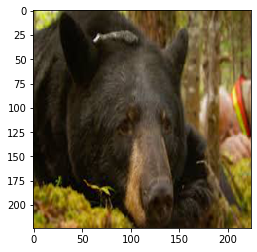

In [5]:
path = "C:\\Users\\gemma\\Documents\\osos\\black\\" 
blackimages = imagenes (path)
print ("Este oso es un black:")

Este oso es un grizzly:


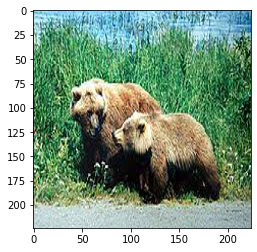

In [6]:
path = "C:\\Users\\gemma\\Documents\\osos\\grizzly\\" 
grizzlyimages = imagenes (path)
print ("Este oso es un grizzly:")

Este oso es de tipo teddy:


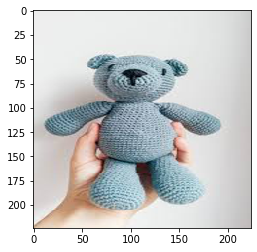

In [7]:
path = "C:\\Users\\gemma\\Documents\\osos\\teddys\\" 
teddysimages = imagenes (path)
print ("Este oso es de tipo teddy:")

Proseguimos con la presentación de las funciones que van a ser esenciales en nuestro proyecto. Iniciamos con la definición de la función para el modelo base de la siguiente manera:

In [8]:
def modelo (path, bmod = "VGG16", inc = False, wth = "imagenet",\
              act1 = "relu", act2 = "softmax", summary = False):
    tipos = len (os.listdir (path))
    primer_model, procesado_previo = fbase (bmod, inc, wth)
    capas = primer_model.output
    capa1 = tf.keras.layers.GlobalAveragePooling2D () (capas)
    capa2 = tf.keras.layers.Dense (512, activation = act1) (capa1) 
    fin_capas = tf.keras.layers.Dense (tipos, activation = act2) (capa2) 
    model = tf.keras.models.Model (inputs = primer_model.input, outputs = fin_capas)
    for layer in model.layers [:len (primer_model.layers)]:
        layer.trainable = False
    for layer in model.layers [len (primer_model.layers):]:
        layer.trainable = True
    if summary == True:
        model.summary ()
    return model, procesado_previo

Han sido escogidos tres modelos de CNN con los que vamos a trabajar:

In [9]:
def fbase (bmod, inc, wth):
    if bmod == "MNet":
        Ma = tf.keras.applications.MobileNetV2
        primer_model = Ma (weights = wth,include_top = inc, input_shape = (224, 224, 3))
        procesado_previo = tf.keras.applications.mobilenet_v2.preprocess_input 
    elif bmod == "Vgg19":
        Ma = tf.keras.applications.VGG19
        primer_model = Ma (weights = wth,include_top = inc)
        procesado_previo = tf.keras.applications.vgg19.preprocess_input 
    else:
        Ma = tf.keras.applications.VGG16
        primer_model = Ma (weights = wth,include_top = inc)
        procesado_previo = tf.keras.applications.vgg16.preprocess_input
    return primer_model, procesado_previo

Para hacer un cálculo del tiempo se utiliza la clase *TimeHistory (https://keras.io/callbacks/)*, que como se indica en el *link* desde el cual se ha encontrado la información acerca de dicha clase, es la manera más sencilla para calcularlo después de cada computación.

In [10]:
class TimeHistory (tf.keras.callbacks.Callback):
    def on_train_begin (self, logs = {}):
        self.times = []
    def on_epoch_begin (self, batch, logs = {}):
        self.epoch_time_start = time.time()
    def on_epoch_end (self, batch, logs = {}):
        self.times.append (time.time () - self.epoch_time_start)

Vamos a utilizar la puntuación que obtengan en el test como un parámetro que nos permita medir cada modelo de otra manera, puntuándolo mejor o peor en función de los aciertos o fallos que vaya teniendo. Debido a que una de las categorías se considera claramente diferenciable, se le otorgará una puntuación de -7 puntos sobre 10 en el caso de confundirla con una de las otras dos. Cuando en cambio el error sea por confundir los osos *black* y *grizzly*, la penalización será menor, de tres puntos sobre diez (como vamos a ver más abajo).
Las imágenes de la carpeta osostest han sido seleccionadas aleatoriamente de internet.

Con la siguiente función se da el puntaje y se establece el porcentaje de acierto en la identificación de los osos de la carpeta osostest. Hemos mencionado que ocurre en caso de cometer un error, pero en caso de acierto se suma un punto. Dicha carpeta consta de 24 imágenes.

In [11]:
def imagen_test (path, model, genera_train, procesado_previo, tamano = (224, 224), num_imagenes = 24.0):
    res = ["black", "grizzly", "teddys",]
    list_images, resultado = random_test (num_imagenes); puntos = 0.0
    clase = {v:k for k, v in genera_train.class_indices.items ()}
    imagen = tf.keras.preprocessing.image
    for i in range (len (list_images)):
        img = imagen.load_img (path + list_images [i]).resize (tamano)
        data = procesado_previo (np.expand_dims (imagen.img_to_array (img), 0))
        predic = model.predict (data)
        pre = clase [np.argmax (predic)]
        if pre == resultado [i]:
            puntos += 1.0
            print ("Test número %i : Tipo de oso = %s -> Solución = %s (+1 pts) \n" % (i+1, pre, resultado [i]))
        else:
            if (pre == res [2] and (resultado [i] == res [0] or resultado [i] == res [0])) or \
                ((pre == res [0] or pre == res [1])  and resultado [i] == res [2]):
                puntos -= 0.70
                print ("Test número %i : Tipo de oso = %s -> Solución = %s (-0.75 pts) \n" % (i+1, pre, resultado [i]))
            else:
                puntos -= 0.30
                print ("Test número %i : Tipo de oso = %s -> Solución = %s (-0.25 pts) \n" % (i+1, pre, resultado [i]))
    print ("_ _ _ _ _\n")
    porcentaje = puntos * 100.0/ num_imagenes
    print ("Puntaje total = %.2f   Nivel de acierto en porcentaje -> %.1f" % (puntos, porcentaje))
    return porcentaje

In [12]:
def random_test (num_imagenes):
    random = []; resultado = []; nume_l = []
    conteo = 0
    while conteo < num_imagenes:
        n = rnd.randint (1, num_imagenes)
        if n not in nume_l:
            random.append ("test%i.jpg" %n)
            if n <= 8:
                resultado.append ("black")
            elif n > 8 and n <= 16:
                resultado.append ("grizzly")
            elif n >= 17 and n <= 24:
                resultado.append ("teddys")
            conteo += 1
            nume_l.append (n)
    return random, resultado

Se introducen las medidas de *crossentropy* y las métricas de *accuracy* en la red neuronal. Información obtenida de: *https://kharshit.github.io/blog/2018/12/07/loss-vs-accuracy* y *https://www.freecodecamp.org/news/how-to-build-your-first-neural-network-to-predict-house-prices-with-keras-f8db83049159/*

In [13]:
def proceso_train (model, genera_train, opt = "Adam",\
                  lr = 0.001, metrics = ["accuracy"], epochs = 5):
    optimizer = optimizador (opt, lr)
    model.compile (optimizer = optimizer, loss = "categorical_crossentropy", metrics = metrics)
    step_size_train = genera_train.n// genera_train.batch_size
    time_callback = TimeHistory ()
    data_model = model.fit_generator (generator = genera_train,\
                                    steps_per_epoch = step_size_train,\
                                    epochs = epochs, callbacks = [time_callback])
    times = time_callback.times
    return data_model, times

La siguiente función procesa las imágenes de la carpeta *train* (o entrenamiento) con el fin de llegar a la optimización para el modelo base. Utilizamos los valores que hemos ido utilizando a lo largo de la asignatura en las prácticas.

In [14]:
def train_p (path, procesado_previo, tamano = (224, 224), batch_size = 2): 
    imagen = tf.keras.preprocessing.image
    data_train = imagen.ImageDataGenerator (preprocessing_function = procesado_previo)
    genera_train = data_train.flow_from_directory (path, target_size = tamano,\
                                                      color_mode = "rgb",\
                                                      batch_size = batch_size,\
                                                      class_mode = "categorical",\
                                                      shuffle = True)  
    return genera_train

La siguiente función utiliza dos algoritmos de optimización de parámetros. Hemos utilizado el de *Adam* y *RMSprop*. Información obtenida de: *ttps://keras.io/optimizers/*

In [15]:
def optimizador (opt, lr):
    if opt == "RMS":
        optimizer = tf.keras.optimizers.RMSprop (learning_rate = lr)
    else :
        optimizer = tf.keras.optimizers.Adam (learning_rate = lr)
    return optimizer

Vamos a relacionar también para cada modelo dos medidas o parámetros: la exactitud que tiene el modelo obtenido y el tiempo que ha tardado en entrenarse con las siguientes líneas de código.

In [16]:
def data_cr (model_fit, times):
    nup = len (model_fit.history ["accuracy"])
    n_row = ["epoch%i" %i for i in range (1, nup + 1)]
    data = pd.concat ([pd.DataFrame (model_fit.history, index = n_row),
                     pd.DataFrame (times, index = n_row)] , axis = 1, sort = False)
    data = data.rename (columns = {0: "time"})
    return data

Como se puede observar, en data_cr hemos hecho uso de la librería *pandas* para crear un *dataframe* que relacionase las dos medidas que acabamos de mencionar.

**MODELOS PREENTRENADOS**

Vamos a utilizar cinco *epoch* para cada modelo base.

In [17]:
bbdd = ["Vgg16", "Vgg19", "MNet"]
def bbdd_comparacion (bbdd):
    model, procesado_previo = modelo (train, bmod = bbdd, summary = True)
    genera_train = train_p (train, procesado_previo)
    fit, times = proceso_train (model, genera_train, epochs = 5)
    data = data_cr (fit, times)
    puntuacion = imagen_test (test, model, genera_train, procesado_previo)
    return data, puntuacion

Para ver cómo funciona la red neuronal *VGG16* ejecutamos la siguiente línea de código:

In [18]:
osos_vgg16, puntos_vgg16 = bbdd_comparacion (bbdd [0])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Podemos ver que son 240 imágenes en total que pertenecen a tres clases. También podemos apreciar las capas, su número y cómo se agrupan, el número de nodos, el número total de parámetros, etc.

A continuación vemos cómo se comporta la red neuronal *VGG19*:

In [19]:
osos_vgg19, puntos_vgg19 = bbdd_comparacion (bbdd [1] )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

Y finalmente, el último tipo de red elegida es la *MobileNet V2*. Información obtenida de: *https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html*

In [20]:
osos_mnet, puntos_mnet = bbdd_comparacion (bbdd [2] )

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

Comparamos los resultados obtenidos en los modelos mediante la realización de un gráfico. Aunque, mirando el puntaje, podemos ver que las tres tienen muy buena puntuación, especialmente la *VGG19* y la *MNet*, que llegan a un nivel de acierto total. En este caso, el gráfico es especialmente importante, ya que añadiendo el tiempo que ha tardado en computarse, esto nos va a ayudar a tomar una decisión:

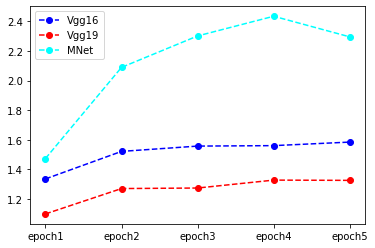

In [21]:
%matplotlib inline
plt.plot (osos_vgg16 ["accuracy"] * 100/ osos_vgg16 ["time"],'--o',\
         color = "Blue" , label = bbdd [0])
plt.plot (osos_vgg19 ["accuracy"] * 100/ osos_vgg19 ["time"],'--o',\
         color = "Red", label = bbdd [1])
plt.plot (osos_mnet ["accuracy"] * 100/ osos_mnet ["time"],'--o',\
         color = "Aqua", label = bbdd [2])
plt.legend (loc = 0)
plt.show ()

Vemos que aunque los tres modelos tienen el mismo porcentaje de acierto, observando el gráfico obtenido, vamos a considerar el último tipo de red neuronal, la *MobileNet V2*, como la red elegida para realizar nuestro trabajo por ser (dentro de los buenos resultados de todas las redes), la que mejores resultados ha dado.

**OPTIMIZADORES**

A continuación procederemos a evaluar los optimizadores ya comentados con la red neuronal elegida.

In [22]:
optimizadores = ["Adam", "RMS"]
def optimizadores_comparados (optimizer):
    model, procesado_previo = modelo (train, bmod = "MNet")
    genera_train = train_p (train, procesado_previo)
    fit, times = proceso_train (model, genera_train, opt = optimizer, epochs = 5)
    data = data_cr (fit, times)
    puntuacion = imagen_test (test, model, genera_train, procesado_previo)
    return data, puntuacion

In [23]:
osos_adam, puntos_adam = optimizadores_comparados (optimizadores [0])

Found 240 images belonging to 3 classes.
  ...
    to  
  ['...']
Train for 120 steps
Epoch 1/5
120/120 [==============================] - 41s 338ms/step - loss: 1.2367 - accuracy: 0.5542
Epoch 2/5
120/120 [==============================] - 35s 289ms/step - loss: 0.7952 - accuracy: 0.6500
Epoch 3/5
120/120 [==============================] - 35s 289ms/step - loss: 0.5895 - accuracy: 0.7667
Epoch 4/5
120/120 [==============================] - 35s 290ms/step - loss: 0.5164 - accuracy: 0.7833
Epoch 5/5
120/120 [==============================] - 34s 285ms/step - loss: 0.5083 - accuracy: 0.7750
Test número 1 : Tipo de oso = black -> Solución = black (+1 pts) 

Test número 2 : Tipo de oso = black -> Solución = black (+1 pts) 

Test número 3 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

Test número 4 : Tipo de oso = grizzly -> Solución = grizzly (+1 pts) 

Test número 5 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

Test número 6 : Tipo de oso = grizzly -> Solución = grizzly (

In [24]:
osos_rms, puntos_rms = optimizadores_comparados (optimizadores [1])

Found 240 images belonging to 3 classes.
  ...
    to  
  ['...']
Train for 120 steps
Epoch 1/5
120/120 [==============================] - 42s 348ms/step - loss: 1.7377 - accuracy: 0.4708
Epoch 2/5
120/120 [==============================] - 34s 287ms/step - loss: 1.0704 - accuracy: 0.5875
Epoch 3/5
120/120 [==============================] - 35s 293ms/step - loss: 0.8428 - accuracy: 0.6875
Epoch 4/5
120/120 [==============================] - 36s 297ms/step - loss: 0.7768 - accuracy: 0.7208
Epoch 5/5
120/120 [==============================] - 36s 296ms/step - loss: 0.6404 - accuracy: 0.7417
Test número 1 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

Test número 2 : Tipo de oso = black -> Solución = black (+1 pts) 

Test número 3 : Tipo de oso = black -> Solución = black (+1 pts) 

Test número 4 : Tipo de oso = black -> Solución = black (+1 pts) 

Test número 5 : Tipo de oso = black -> Solución = black (+1 pts) 

Test número 6 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

Comparamos los dos algoritmos de optimización:

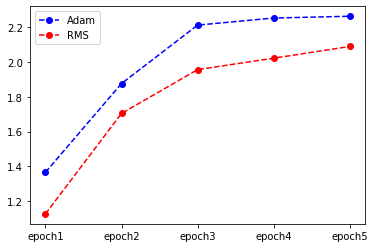

In [25]:
plt.plot (osos_adam ["accuracy"] * 100/ osos_adam ["time"],'--o',\
         color = "Blue" , label = optimizadores [0])
plt.plot (osos_rms ["accuracy"] * 100/ osos_rms ["time"],'--o',\
         color = "Red", label = optimizadores [1])
plt.legend (loc = 0)
plt.show ()

Y, observando el gráfico obtenido, concretamente la métrica de precisión o *accuracy*, el algoritmo elegido es el de Adam, ya que es el que tiene una subida sostenida, por lo que es con el que continuaremos trabajando.

**LEARNING RATE**

Analizamos el *learning rate*:

In [26]:
learningrate = [0.001, 0.01]
def lr_comparado (lr):
    model, procesado_previo = modelo (train, bmod = "MNet")
    genera_train = train_p (train, procesado_previo, batch_size = 5)
    fit, times = proceso_train (model, genera_train, opt = "Adam", epochs = 5, lr = lr)
    data = data_cr (fit, times)
    puntuacion = imagen_test (test, model, genera_train, procesado_previo)
    return data, puntuacion

In [27]:
osos_lr2, puntos_lr2 = lr_comparado (learningrate [0])

Found 240 images belonging to 3 classes.
  ...
    to  
  ['...']
Train for 48 steps
Epoch 1/5
48/48 [==============================] - 40s 833ms/step - loss: 0.7794 - accuracy: 0.7208
Epoch 2/5
48/48 [==============================] - 35s 721ms/step - loss: 0.2890 - accuracy: 0.8917
Epoch 3/5
48/48 [==============================] - 35s 726ms/step - loss: 0.1441 - accuracy: 0.9333
Epoch 4/5
48/48 [==============================] - 35s 739ms/step - loss: 0.1089 - accuracy: 0.9708
Epoch 5/5
48/48 [==============================] - 35s 725ms/step - loss: 0.0743 - accuracy: 0.9792
Test número 1 : Tipo de oso = black -> Solución = black (+1 pts) 

Test número 2 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

Test número 3 : Tipo de oso = grizzly -> Solución = grizzly (+1 pts) 

Test número 4 : Tipo de oso = black -> Solución = black (+1 pts) 

Test número 5 : Tipo de oso = grizzly -> Solución = grizzly (+1 pts) 

Test número 6 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

T

In [28]:
osos_lr3, puntos_lr3 = lr_comparado (learningrate [1])

Found 240 images belonging to 3 classes.
  ...
    to  
  ['...']
Train for 48 steps
Epoch 1/5
48/48 [==============================] - 41s 845ms/step - loss: 6.3525 - accuracy: 0.6583
Epoch 2/5
48/48 [==============================] - 35s 724ms/step - loss: 0.5413 - accuracy: 0.8708
Epoch 3/5
48/48 [==============================] - 35s 727ms/step - loss: 0.3041 - accuracy: 0.9292
Epoch 4/5
48/48 [==============================] - 35s 723ms/step - loss: 0.0751 - accuracy: 0.9792
Epoch 5/5
48/48 [==============================] - 35s 723ms/step - loss: 0.0199 - accuracy: 1.0000
Test número 1 : Tipo de oso = grizzly -> Solución = black (-0.25 pts) 

Test número 2 : Tipo de oso = black -> Solución = black (+1 pts) 

Test número 3 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

Test número 4 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

Test número 5 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

Test número 6 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 



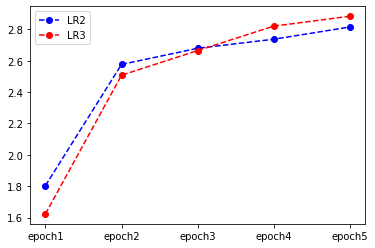

In [29]:
rate = ["LR2", "LR3"]
plt.plot (osos_lr2 ["accuracy"] * 100/ osos_lr2 ["time"],'--o',\
         color = "Blue", label = str (rate [0]))
plt.plot (osos_lr3 ["accuracy"] * 100/ osos_lr3 ["time"],'--o',\
         color = "Red", label = str (rate [1]))
plt.legend (loc = 0)
plt.show ()

Podemos comprobar cómo el learning rate más bajo, el 3, es más efectivo.

**FUNCIONES DE ACTIVACIÓN**

Finalmente procedemos a estudiar la combinación de varios tipos de funciones de activación, pero solamente para las últimas capas, ya que el resto han sido elegidos en los análisis ya realizados:

In [30]:
funciondeactivacion = [["relu", "softmax"], ["tanh", "softmax"]]
def factiv_comparadas (act1, act2):
    model, procesado_previo = modelo (train, bmod = "MNet", act1 = act1, act2 = act2)
    genera_train = train_p (train, procesado_previo, batch_size = 5)
    fit, times = proceso_train (model, genera_train, epochs = 5, lr = 1E-3)
    data = data_cr (fit, times)
    puntuacion = imagen_test (test, model, genera_train, procesado_previo)
    return data, puntuacion

In [31]:
osos_act1, puntos_act4 = factiv_comparadas (funciondeactivacion [0][0],\
                                             funciondeactivacion [0][1])

Found 240 images belonging to 3 classes.
  ...
    to  
  ['...']
Train for 48 steps
Epoch 1/5
48/48 [==============================] - 41s 845ms/step - loss: 1.0283 - accuracy: 0.6375
Epoch 2/5
48/48 [==============================] - 34s 718ms/step - loss: 0.2881 - accuracy: 0.8958
Epoch 3/5
48/48 [==============================] - 35s 728ms/step - loss: 0.1896 - accuracy: 0.9333
Epoch 4/5
48/48 [==============================] - 35s 722ms/step - loss: 0.1037 - accuracy: 0.9625
Epoch 5/5
48/48 [==============================] - 35s 722ms/step - loss: 0.1192 - accuracy: 0.9625
Test número 1 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

Test número 2 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

Test número 3 : Tipo de oso = grizzly -> Solución = grizzly (+1 pts) 

Test número 4 : Tipo de oso = black -> Solución = black (+1 pts) 

Test número 5 : Tipo de oso = black -> Solución = black (+1 pts) 

Test número 6 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

Tes

In [32]:
osos_act4, puntos_act1 = factiv_comparadas (funciondeactivacion [1][0],\
                                             funciondeactivacion [1][1])

Found 240 images belonging to 3 classes.
  ...
    to  
  ['...']
Train for 48 steps
Epoch 1/5
48/48 [==============================] - 41s 864ms/step - loss: 0.7658 - accuracy: 0.7583
Epoch 2/5
48/48 [==============================] - 35s 729ms/step - loss: 0.3824 - accuracy: 0.8458
Epoch 3/5
48/48 [==============================] - 35s 723ms/step - loss: 0.0666 - accuracy: 0.9750
Epoch 4/5
48/48 [==============================] - 34s 714ms/step - loss: 0.0230 - accuracy: 0.9958
Epoch 5/5
48/48 [==============================] - 34s 717ms/step - loss: 0.0082 - accuracy: 1.0000
Test número 1 : Tipo de oso = black -> Solución = black (+1 pts) 

Test número 2 : Tipo de oso = grizzly -> Solución = grizzly (+1 pts) 

Test número 3 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

Test número 4 : Tipo de oso = grizzly -> Solución = grizzly (+1 pts) 

Test número 5 : Tipo de oso = black -> Solución = black (+1 pts) 

Test número 6 : Tipo de oso = teddys -> Solución = teddys (+1 pts) 

T

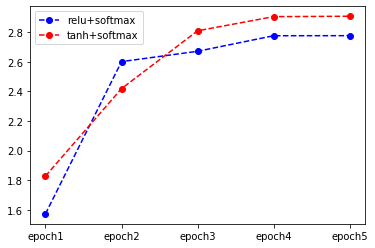

In [33]:
activa = ["relu+softmax", "tanh+softmax"]
plt.plot (osos_act1 ["accuracy"] * 100/ osos_act1 ["time"],'--o',\
         color = "Blue" , label = activa [0])
plt.plot (osos_act4 ["accuracy"] * 100/ osos_act4 ["time"],'--o',\
         color = "Red", label = activa [1])
plt.legend (loc = 0)
plt.show()

Gracias al gráfico vemos como *tanh+softmax* constituye la mejor combinación de activadores para que el modelo tenga éxito. Hemos decidido obviar los activadores que daban una tasa de acierto nula.

Hemos medido el rendimiento del test a través de los parámetros de *accuracy*, tiempo y puntaje en cada test. Comprobamos que el resto de indicadores medidos hacen que la exactitud del modelo no varíe en exceso con la excepción de la eleción de las funciones de activación, que es de gran importancia.

Finalmente, podemos pasar a recordar que el modelo de red neuronal elegido ha sido la ***MobileNet V2***, el tipo de optimizador **Adam**, el learning rate el **3** y la función de activación ***tanh+softmax***.